In [181]:
%load_ext autoreload
%autoreload 2
import sys

notebook_dir = "/Net/Groups/BGI/scratch/mzehner/code/stacathome/"
sys.path.append(notebook_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
from stacathome.utils import parse_dec_to_lon_lat_point
from stacathome.request import probe_request
from stacathome.utils import get_transform, get_utm_crs_from_lon_lat
from shapely import buffer, transform, box
import numpy as np
import pyinterp
import xarray as xr
import fsspec

fname, position_str = ('AU-Dry', '-15.2588, 132.3706')
position = parse_dec_to_lon_lat_point(position_str)

In [183]:
collection = "sentinel-3-synergy-syn-l2-netcdf"
workdir = '/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts'
time_range = {
    collection: (2018, 2025),
}
edge_length_m = 3000

In [184]:
crs_code = get_utm_crs_from_lon_lat(position.x, position.y)
tr = get_transform(4326, crs_code)
tr_back = get_transform(crs_code, 4326)
point_utm = transform(position, tr)
distance_in_m = edge_length_m
bbox_wgs84 = transform(box(*buffer(point_utm, distance_in_m / 2).bounds), tr_back)


In [185]:
X0, Y0, X1, Y1 = bbox_wgs84.bounds

mesh = pyinterp.RTree()
resampled_X = np.linspace(X0, X1, int(distance_in_m / 300))
resampled_Y = np.linspace(Y0, Y1, int(distance_in_m / 300))
                          
mx, my = np.meshgrid(resampled_X,
                     resampled_Y,
                     indexing='ij')
meshstack = np.vstack((mx.ravel(), my.ravel())).T

In [186]:
probe_dict = probe_request(
    point_wgs84=position, distance_in_m=edge_length_m, collection=[collection], return_box=True, limit=9999
)

In [187]:
from stacathome.download import get_asset
import os
for i in range(len(probe_dict['sentinel-3-synergy-syn-l2-netcdf'][0])):
    for a in probe_dict['sentinel-3-synergy-syn-l2-netcdf'][0][i].assets:
        href = probe_dict['sentinel-3-synergy-syn-l2-netcdf'][0][i].assets[a].href
        out_path = os.path.join(workdir, fname, href.split('/')[-2], '_'.join(href.split('/')[-1:]))
        if not os.path.exists(out_path):
            break
            print(f"Downloading {href} to {out_path}")
            #get_asset(href, out_path)
        else:
            probe_dict['sentinel-3-synergy-syn-l2-netcdf'][0][i].assets[a].href = out_path

In [188]:
items_to_test = probe_dict['sentinel-3-synergy-syn-l2-netcdf'][0][500:600]

itemnr = 9

In [189]:
timeax = np.array([np.datetime64(item.properties['datetime'][:-1]) for item in items_to_test])

In [190]:
keys = [
    'syn-amin',
    'syn-flags',
    'syn-ato550',
    # 'tiepoints-olci',
    # 'tiepoints-meteo',
    # 'tiepoints-slstr-n',
    # 'tiepoints-slstr-o',
    'syn-angstrom-exp550',
    'syn-s1n-reflectance',
    'syn-s1o-reflectance',
    'syn-s2n-reflectance',
    'syn-s2o-reflectance',
    'syn-s3n-reflectance',
    'syn-s3o-reflectance',
    'syn-s5n-reflectance',
    'syn-s5o-reflectance',
    'syn-s6n-reflectance',
    'syn-s6o-reflectance',
    'syn-oa01-reflectance',
    'syn-oa02-reflectance',
    'syn-oa03-reflectance',
    'syn-oa04-reflectance',
    'syn-oa05-reflectance',
    'syn-oa06-reflectance',
    'syn-oa07-reflectance',
    'syn-oa08-reflectance',
    'syn-oa09-reflectance',
    'syn-oa10-reflectance',
    'syn-oa11-reflectance',
    'syn-oa12-reflectance',
    'syn-oa16-reflectance',
    'syn-oa17-reflectance',
    'syn-oa18-reflectance',
    'syn-oa21-reflectance',
    # 'syn-sdr-removed-pixels',
    # 'annotations-removed-pixels'
]

In [191]:
values = np.zeros((len(keys)*2+1, len(items_to_test), len(resampled_Y), len(resampled_X)), dtype=np.float32)

In [192]:
%%time
varlist = []
for t_index, item in enumerate(items_to_test[:1]):
    print(item.properties['datetime'])
    
    geo = xr.open_dataset(fsspec.open(item.assets["geolocation"].href).open())
    lats = geo['lat'].values.flatten()
    lons = geo['lon'].values.flatten()

    mask = np.where((lats > Y0) & (lats < Y1) & (lons > X0) & (lons < X1))

    lats, lons = lats[mask], lons[mask]
    lonlatstack = np.vstack((lons, lats)).T  # Precomputed for all k
    
    # Use np.arange to create an index mapping
    index_map = np.arange(len(lonlatstack))
    mesh.packing(lonlatstack, index_map)
    idw_index, _ = mesh.inverse_distance_weighting(
        meshstack,
        within=False,  # No extrapolation
        k=1,  # Find 1 nearest neighbor
        num_threads=0
    )
    idw_index = idw_index.astype(np.int32)
    pointer_var = 0
    for k in keys:
        dataset = xr.open_dataset(fsspec.open(item.assets[k].href).open())
        for var in list(dataset.data_vars):
            if t_index == 0:
                varlist.append(var)
            
            data = dataset[var].values.flatten()[mask]
            idw = data[idw_index].reshape(mx.shape)
            values_2[pointer_var, t_index] = idw
            
            pointer_var += 1

2022-08-12T00:51:10.955302Z
CPU times: user 14.8 s, sys: 3.28 s, total: 18.1 s
Wall time: 18.8 s


In [193]:
items_to_test[77]

<Item id=S3A_SY_2_SYN_20220525T003633_20220525T003933_0180_085_330_3240>

In [194]:
orbit_dir = np.array([item.properties['sat:orbit_state'] for item in items_to_test])
abs_orbit = np.array([item.properties['sat:absolute_orbit'] for item in items_to_test])
rel_orbit = np.array([item.properties['sat:relative_orbit'] for item in items_to_test])

In [195]:
rel_orbit

array([159, 273, 259, 116, 102, 216, 202,  59,  45,   2, 373, 116, 102,
       330, 316,  59,  45, 273, 259,   2, 373, 216, 202, 330, 316, 173,
       159, 273, 259, 116, 102, 216, 202,  59,  45, 159,   2, 373, 116,
       102, 330, 316,  59,  45, 273, 259,   2, 373, 216, 202, 330, 316,
       173, 159, 273, 259, 116, 102, 216, 202,  59,  45, 159,   2, 373,
       116, 102, 330, 316,  59,  45, 273, 259,   2, 373, 216, 202, 330,
       316, 173, 159, 259, 116, 102, 216, 202,  59, 159,   2, 373, 116,
       102, 330, 316,  59,  45, 273, 259,   2, 373])

In [178]:
orbit_dir

array(['descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'descending',
       'descending', 'descending', 'descending', 'desce

In [172]:
geo

<xarray.Dataset> Size: 3kB
Dimensions:   (rows: 14, columns: 15)
Dimensions without coordinates: rows, columns
Data variables:
    altitude  (rows, columns) float32 840B nan nan nan nan ... nan nan nan nan
    lat       (rows, columns) float32 840B nan nan nan nan ... nan nan nan nan
    lon       (rows, columns) float32 840B nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    absolute_orbit_number:  22376
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2022-08-13T04:57:47Z
    history:                  2022-08-13T04:57:47Z: PUGCoreProcessor JobOrder...
    institution:            PS2
    ...                     ...
    references:             S3IPF PDS 006 - i1r13 - Product Data Format Speci...
    resolution:             [ 300 300 ]
    source:                 IPF-SY-2 06.22
    start_time:             2022-08-12T00:49:40.988589Z
    stop_time:              2022-08-12T00:52:40.912432Z
    title:                  SYN L2, high resolution georeferencing data

In [136]:
varlist

['A550',
 'AMIN',
 'CLOUD_flags',
 'OLC_flags',
 'SLN_flags',
 'SLO_flags',
 'SYN_flags',
 'SDR_Oa01',
 'SDR_Oa01_err',
 'SDR_Oa02',
 'SDR_Oa02_err',
 'SDR_Oa03',
 'SDR_Oa03_err',
 'SDR_Oa04',
 'SDR_Oa04_err',
 'SDR_Oa05',
 'SDR_Oa05_err',
 'SDR_Oa06',
 'SDR_Oa06_err',
 'SDR_Oa07',
 'SDR_Oa07_err',
 'SDR_Oa08',
 'SDR_Oa08_err',
 'SDR_Oa09',
 'SDR_Oa09_err',
 'SDR_Oa10',
 'SDR_Oa10_err',
 'SDR_Oa11',
 'SDR_Oa11_err',
 'SDR_Oa12',
 'SDR_Oa12_err',
 'SDR_Oa16',
 'SDR_Oa16_err',
 'SDR_Oa17',
 'SDR_Oa17_err',
 'SDR_Oa18',
 'SDR_Oa18_err',
 'SDR_Oa21',
 'SDR_Oa21_err',
 'SDR_S1N',
 'SDR_S1N_err',
 'SDR_S1O',
 'SDR_S1O_err',
 'SDR_S2N',
 'SDR_S2N_err',
 'SDR_S2O',
 'SDR_S2O_err',
 'SDR_S3N',
 'SDR_S3N_err',
 'SDR_S3O',
 'SDR_S3O_err',
 'SDR_S5N',
 'SDR_S5N_err',
 'SDR_S5O',
 'SDR_S5O_err',
 'SDR_S6N',
 'SDR_S6N_err',
 'SDR_S6O',
 'SDR_S6O_err',
 'T550',
 'T550_err']

In [140]:
varlist_2.index('SDR_Oa01')

29

In [147]:
for var_name in varlist:
    print(var_name)
    print(values[varlist.index(var_name),0] - values_2[varlist_2.index(var_name),0])
#values[varlist.index(var_name),0] - values_2[varlist_2.index(var_name),0]

A550
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
AMIN
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
CLOUD_flags
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

In [148]:
values[varlist.index('SLO_flags'),0]

array([[264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264224., 264224.],
       [264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264224., 264224.],
       [264192., 264192., 264192., 264192., 395264., 395264., 264192.,
        264192., 264192., 264192.],
       [264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264192., 264192.],
       [395264., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264192., 264192.],
       [395264., 264192., 264192., 264224., 264192., 264224., 264224.,
        264192., 264192., 264192.],
       [264192., 264192., 264224., 264192., 264192., 395264., 395264.,
        264192., 264192., 264192.],
       [264192., 264192., 264224., 264192., 264192., 395264., 264192.,
        264192., 264192., 264192.],
       [264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264192., 264192.],
       [264192., 264192., 264192., 26

In [149]:
values_2[varlist_2.index('SLO_flags'),0]

array([[264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264224., 264224.],
       [264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264224., 264224.],
       [264192., 264192., 264192., 264192., 395264., 395264., 264192.,
        264192., 264192., 264192.],
       [264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264192., 264192.],
       [395264., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264192., 264192.],
       [395264., 264192., 264192., 264224., 264192., 264224., 264224.,
        264192., 264192., 264192.],
       [264192., 264192., 264224., 264192., 264192., 395264., 395264.,
        264192., 264192., 264192.],
       [264192., 264192., 264224., 264192., 264192., 264192., 264192.,
        264192., 264192., 264192.],
       [264192., 264192., 264192., 264192., 264192., 264192., 264192.,
        264192., 264192., 264192.],
       [264192., 264192., 264192., 26

In [102]:
for i in range(len(keys)):
    print(np.unique(values[i,0] == values_2[i,0]))

[ True]
[ True]
[False  True]
[ True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]
[False  True]


In [91]:
print(values[i,:3] - values_2[i,:3])

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.00510001  0.         ...  0.          0.
    0.        ]
  [ 0.00510001  0.          0.         ...  0.          0.
    0.00980002]
  [ 0.          0.          0.         ...  0.          0.
    0.00980002]]

 [[-0.0415     -0.0415     -0.0415     ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.         -0.0396     ...  0.          0.
    0.        ]
  [ 0.   

In [86]:
values_2[:,:3] == values[:,:3]

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  T

In [ ]:
ds = xr.open_mfdataset([item.assets[k].href for k in keys], engine="netcdf4", parallel=True)

In [ ]:
mesh.packing(lonlatstack, np.arange(len(lonlatstack)))
idw, neighbors = mesh.inverse_distance_weighting(
    meshstack,
    within=False,  # Extrapolation is forbidden
    k=1,  # We are looking for at most 11 neighbors
    num_threads=0)

In [60]:
idw

array([129., 129., 132., 130., 130., 108., 127.,  95., 119., 106., 106.,
        93.,  79.,  79.,  79.,  63.,  63.,  48.,  48.,  34., 129., 129.,
       132., 121., 108., 108.,  95., 119.,  82., 106.,  67.,  93.,  93.,
        79.,  79.,  63.,  63.,  48.,  48.,  34., 129., 129., 121., 131.,
       109., 128.,  96., 120.,  82., 106.,  67.,  93.,  52.,  80.,  38.,
        65.,  24.,  48.,  34.,  34., 129., 122., 122., 131., 109., 128.,
        96., 120.,  83., 107.,  68.,  94.,  52.,  38.,  38.,  24.,  50.,
        14.,  36.,   4., 122., 122., 122., 110., 110.,  97.,  97.,  84.,
        83.,  68.,  68.,  53.,  81.,  39.,  66.,  25.,  51.,  14.,  36.,
         4., 124., 124., 124., 112., 110.,  97.,  97.,  84.,  84.,  69.,
        54.,  54.,  81.,  39.,  66.,  25.,  51.,  15.,  37.,   5., 124.,
       124., 124., 112., 112.,  98.,  86.,  86.,  69.,  69.,  54.,  54.,
        40.,  40.,  26.,  26.,  15.,  15.,   5.,   5., 125., 125., 113.,
       113.,  98.,  98.,  86.,  86.,  71.,  71.,  5

In [59]:
neighbors

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

In [47]:
mesh.bounds()

AttributeError: 'NoneType' object has no attribute 'bounds'

In [190]:
import xarray as xr

# Create a new xarray dataset
ds = xr.Dataset(
    coords={
        "lon": resampled_X,
        "lat": resampled_Y,
        "time": timeax.astype('datetime64[ns]')
    },
    attrs={"crs": 4326,
           "Dataset": "Sentinel-3 OLCI Level 2 data regridded"}
    
)


In [192]:
for i, k in enumerate(keys):
    ds[k] = xr.DataArray(
        values[i],
        dims=("time", "lat", "lon"),
    )

In [ ]:
ds = ds.sortby('time')

<xarray.Dataset> Size: 5MB
Dimensions:               (lon: 20, lat: 20, time: 100)
Coordinates:
  * lon                   (lon) float64 160B 132.4 132.4 132.4 ... 132.4 132.4
  * lat                   (lat) float64 160B -15.27 -15.27 ... -15.25 -15.25
  * time                  (time) datetime64[ns] 800B 2022-08-12T00:51:10.9553...
Data variables: (12/30)
    syn-amin              (time, lat, lon) float32 160kB 1.0 1.0 1.0 ... 1.0 1.0
    syn-flags             (time, lat, lon) float32 160kB 0.0 0.0 0.0 ... 0.0 0.0
    syn-ato550            (time, lat, lon) float32 160kB 0.1477 ... 0.1295
    syn-angstrom-exp550   (time, lat, lon) float32 160kB 1.085 1.085 ... 1.085
    syn-s1n-reflectance   (time, lat, lon) float32 160kB 0.1075 ... 0.0792
    syn-s1o-reflectance   (time, lat, lon) float32 160kB 0.085 0.085 ... 0.0709
    ...                    ...
    syn-oa11-reflectance  (time, lat, lon) float32 160kB 0.1555 ... 0.1158
    syn-oa12-reflectance  (time, lat, lon) float32 160kB 0.2371 ... 0.2146
    syn-oa16-reflectance  (time, lat, lon) float32 160kB 0.2457 0.2457 ... 0.224
    syn-oa17-reflectance  (time, lat, lon) float32 160kB 0.2783 ... 0.2564
    syn-oa18-reflectance  (time, lat, lon) float32 160kB 0.2846 ... 0.2607
    syn-oa21-reflectance  (time, lat, lon) float32 160kB 0.32 0.32 ... 0.2982
Attributes:
    crs:      4326
    Dataset:  Sentinel-3 OLCI Level 2 data regridded

In [201]:
# Display the dataset
import zarr
import zipfile
out_path = os.path.join(workdir, fname, "Sample.zarr.zip")
store = zarr.ZipStore(out_path, mode="w", compression=zipfile.ZIP_BZIP2)
ds.to_zarr(store, mode="w", consolidated=True)
store.close()

In [202]:
xr.open_zarr(out_path)

<xarray.Dataset> Size: 5MB
Dimensions:               (lat: 20, lon: 20, time: 100)
Coordinates:
  * lat                   (lat) float64 160B -15.27 -15.27 ... -15.25 -15.25
  * lon                   (lon) float64 160B 132.4 132.4 132.4 ... 132.4 132.4
  * time                  (time) datetime64[ns] 800B 2022-05-01T01:00:31.4781...
Data variables: (12/30)
    syn-amin              (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-angstrom-exp550   (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-ato550            (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-flags             (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-oa01-reflectance  (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-oa02-reflectance  (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    ...                    ...
    syn-s3n-reflectance   (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-s3o-reflectance   (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-s5n-reflectance   (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-s5o-reflectance   (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-s6n-reflectance   (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
    syn-s6o-reflectance   (time, lat, lon) float32 160kB dask.array<chunksize=(100, 20, 20), meta=np.ndarray>
Attributes:
    Dataset:  Sentinel-3 OLCI Level 2 data regridded
    crs:      4326

In [ ]:

geo = xr.open_dataset(fsspec.open(items_to_test[itemnr].assets["geolocation"].href).open())

lats = geo['lat'].values.flatten()
lons = geo['lon'].values.flatten()

mask = np.where((lats > Y0) & (lats < Y1) & (lons > X0) & (lons < X1))

lats = lats[mask]
lons = lons[mask]

lonlatstack = np.vstack((lons, lats)).T

In [123]:
# for k in keys:
#     dataset = xr.open_dataset(fsspec.open(items_to_test[itemnr].assets[k].href).open())
#     print(k, dataset[list(dataset.data_vars)[0]].values.shape)

In [137]:
dataset = xr.open_dataset(fsspec.open(items_to_test[itemnr].assets[keys[-1]].href).open())

In [138]:
data = dataset[list(dataset.data_vars)[0]].values.flatten()
data = data[mask]

mesh.packing(lonlatstack, data)

In [141]:
%%time
wf, neighbors = mesh.window_function(
    meshstack,
    within=False,  # Extrapolation is forbidden
    k=11,
    wf='parzen',
    num_threads=0)
wf = wf.reshape(mx.shape)

CPU times: user 5.94 ms, sys: 7.09 ms, total: 13 ms
Wall time: 6.71 ms


In [170]:
%%time
idw, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.ravel(), my.ravel())).T,
    within=False,  # Extrapolation is forbidden
    k=1,  # We are looking for at most 11 neighbors
    num_threads=0)
idw = idw.reshape(mx.shape)

CPU times: user 1.55 ms, sys: 10.6 ms, total: 12.1 ms
Wall time: 7.15 ms


In [54]:
%%time
rbf, neighbors = mesh.radial_basis_function(
    np.vstack((mx.ravel(), my.ravel())).T,
    within=False,  # Extrapolation is forbidden
    k=11,  # We are looking for at most 11 neighbors
    rbf='linear',
    smooth=1e-4,
    num_threads=0)
rbf = rbf.reshape(mx.shape)

CPU times: user 13.7 ms, sys: 8.71 ms, total: 22.4 ms
Wall time: 20.5 ms


In [55]:
%%time
wf, neighbors = mesh.window_function(
    np.vstack((mx.ravel(), my.ravel())).T,
    within=False,  # Extrapolation is forbidden
    k=11,
    wf='parzen',
    num_threads=0)
wf = wf.reshape(mx.shape)

CPU times: user 7.86 ms, sys: 5.45 ms, total: 13.3 ms
Wall time: 4.56 ms


In [56]:
%%time
kriging, neighbors = mesh.universal_kriging(
    np.vstack((mx.ravel(), my.ravel())).T,
    within=False,  # Extrapolation is forbidden
    k=11,
    covariance='matern_12',
    alpha=100_000,
    num_threads=0)
kriging = kriging.reshape(mx.shape)

CPU times: user 8.47 ms, sys: 16.6 ms, total: 25.1 ms
Wall time: 30 ms


Text(0, 0.5, 'lat')

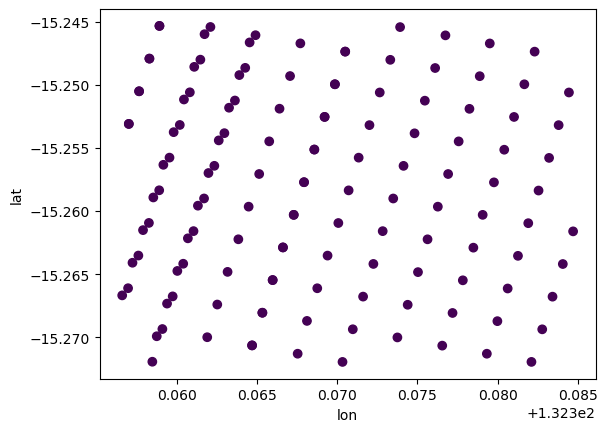

In [57]:
import matplotlib.pyplot as plt
plt.scatter(lons, lats, c=data)  # plot grid locations
plt.xlabel("lon")
plt.ylabel("lat")

ValueError: not enough values to unpack (expected 2, got 1)

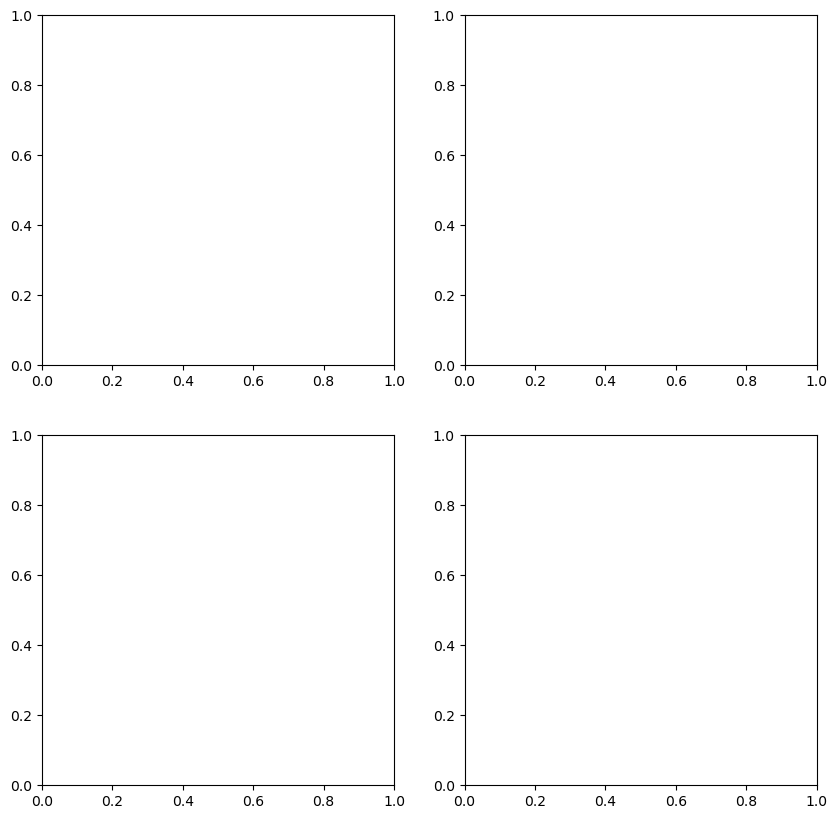

In [58]:
import matplotlib.pyplot as plt

# Define your global vmin and vmax
vmin = min(idw.min(), rbf.min(), wf.min(), kriging.min())
vmax = max(idw.max(), rbf.max(), wf.max(), kriging.max())

# Create a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust the size accordingly

# Plot for IDW interpolation
pcm = axs[0, 0].pcolormesh(mx, my, idw, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('IDW interpolation')

# Plot for RBF interpolation
pcm = axs[0, 1].pcolormesh(mx, my, rbf, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('RBF interpolation')

# Plot for Window function interpolation
pcm = axs[1, 0].pcolormesh(mx, my, wf, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Window function interpolation')

# Plot for Universal Kriging interpolation
pcm = axs[1, 1].pcolormesh(mx, my, kriging, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Universal Kriging interpolation')

# Add colorbar to the right side of the plot
cbar = fig.colorbar(pcm, ax=axs, orientation='horizontal', fraction=0.02, pad=0.06)
# Adjust layout to avoid overlap

# Show the plot
plt.show()


In [169]:
resampled_X, resampled_Y

(array([132.35647578, 132.35796244, 132.35944911, 132.36093578,
        132.36242244, 132.36390911, 132.36539578, 132.36688244,
        132.36836911, 132.36985577, 132.37134244, 132.37282911,
        132.37431577, 132.37580244, 132.37728911, 132.37877577,
        132.38026244, 132.38174911, 132.38323577, 132.38472244]),
 array([-15.27251062, -15.27106736, -15.26962411, -15.26818086,
        -15.2667376 , -15.26529435, -15.2638511 , -15.26240784,
        -15.26096459, -15.25952134, -15.25807808, -15.25663483,
        -15.25519158, -15.25374832, -15.25230507, -15.25086182,
        -15.24941856, -15.24797531, -15.24653206, -15.2450888 ]))

In [88]:
import xarray as xr

# Create a new xarray dataset
ds = xr.Dataset(
    {
        "idw": (["lon", "lat"], idw)
    },
    coords={
        "lon": resampled_X,
        "lat": resampled_Y,
        "time": timeax.astype('datetime64[ns]')
    },
    attrs={"crs": 4326,
           "Dataset": "Sentinel-3 OLCI Level 2 data regridded"}
    
)

# Display the dataset
ds.to_zarr("test.zarr", mode="w", compute=False)

Delayed('_finalize_store-395ebadc-9c77-46e3-8f74-d36f9746a293')

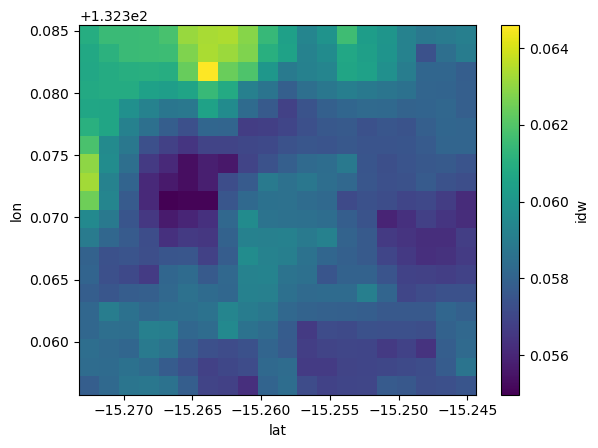

In [175]:
ds.idw.plot()

In [227]:
import xarray as xr

ds = xr.open_zarr('/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts/AU-Dry/S3A_SY_2_SYN____20241216T011001_20241216T011301_20241217T192203_0179_120_202_3240_PS1_O_NT_002.SEN3.zarr.zip')

In [214]:
ds.AMIN.where(ds.AMIN.isnan(), drop=True).plot()

AttributeError: 'DataArray' object has no attribute 'isnan'

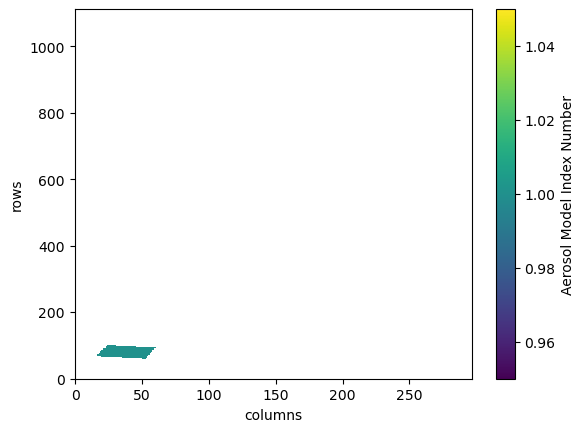

In [209]:
ds.AMIN.plot()

In [217]:
ds['lat'] = ds['lat'].where(~np.isnan(ds['AMIN']))
ds['lon'] = ds['lon'].where(~np.isnan(ds['AMIN']))

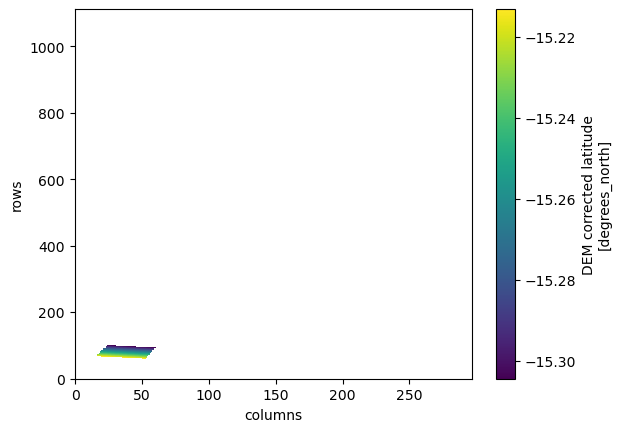

In [218]:
ds['lat'].plot()

In [228]:
ds = ds.dropna(dim='rows', how='all')
ds = ds.dropna(dim='columns', how='all')

In [229]:
ds

<xarray.Dataset> Size: 480kB
Dimensions:       (rows: 41, columns: 45)
Coordinates:
    lat           (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    lon           (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
Dimensions without coordinates: rows, columns
Data variables: (12/61)
    A550          (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    AMIN          (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    CLOUD_flags   (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    OLC_flags     (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    SDR_Oa01      (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    SDR_Oa01_err  (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    ...            ...
    SDR_S6O_err   (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    SLN_flags     (rows, columns) float64 15kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    SLO_flags     (rows, columns) float64 15kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    SYN_flags     (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    T550          (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
    T550_err      (rows, columns) float32 7kB dask.array<chunksize=(41, 45), meta=np.ndarray>
Attributes: (12/14)
    absolute_orbit_number:  45990
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2024-12-17T19:22:03Z
    history:                  2024-12-17T19:22:03Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    product_name:           S3A_SY_2_SYN____20241216T011001_20241216T011301_2...
    references:             S3IPF PDS 006 - i1r16 - Product Data Format Speci...
    resolution:             [ 300 300 ]
    source:                 IPF-SY-2 06.29
    start_time:             2024-12-16T01:10:01.406796Z
    stop_time:              2024-12-16T01:13:01.371900Z

In [220]:
ds.squeeze()

<xarray.Dataset> Size: 86MB
Dimensions:       (rows: 1112, columns: 297)
Coordinates:
    lat           (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    lon           (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
Dimensions without coordinates: rows, columns
Data variables: (12/61)
    A550          (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    AMIN          (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    CLOUD_flags   (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    OLC_flags     (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    SDR_Oa01      (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    SDR_Oa01_err  (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    ...            ...
    SDR_S6O_err   (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    SLN_flags     (rows, columns) float64 3MB dask.array<chunksize=(278, 149), meta=np.ndarray>
    SLO_flags     (rows, columns) float64 3MB dask.array<chunksize=(278, 149), meta=np.ndarray>
    SYN_flags     (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    T550          (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
    T550_err      (rows, columns) float32 1MB dask.array<chunksize=(556, 149), meta=np.ndarray>
Attributes: (12/14)
    absolute_orbit_number:  45990
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2024-12-17T19:22:03Z
    history:                  2024-12-17T19:22:03Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    product_name:           S3A_SY_2_SYN____20241216T011001_20241216T011301_2...
    references:             S3IPF PDS 006 - i1r16 - Product Data Format Speci...
    resolution:             [ 300 300 ]
    source:                 IPF-SY-2 06.29
    start_time:             2024-12-16T01:10:01.406796Z
    stop_time:              2024-12-16T01:13:01.371900Z

In [233]:
workdir = '/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts'
fname = 'AU-Dry'
json_file = f"{workdir}/{fname}_S3_query.json"

In [234]:
os.path.exists(json_file)

False

In [235]:
json_file

'/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts/AU-Dry_S3_query.json'

In [238]:
import json
json_file = os.path.join(workdir, fname, f"{fname}_S3_query.json")
if os.path.exists(json_file):
            with open(json_file, "r") as f:
                query_dict = json.load(f)

In [244]:
len(query_dict['features'])

1793

In [243]:
query_dict.keys()

dict_keys(['type', 'features'])

In [ ]:
'/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts/AU-Dry/AU-Dry_S3_query.json'

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import os
import json
from concurrent.futures import ThreadPoolExecutor
from itertools import repeat

from pystac import Item

notebook_dir = "/Net/Groups/BGI/scratch/mzehner/code/stacathome/"
sys.path.append(notebook_dir)


from stacathome.sentinel_3_utils import load_s3_cube, cut_s3_cubes
from stacathome.request import probe_request
from stacathome.utils import parse_dec_to_lon_lat_point, parse_dms_to_lon_lat_point
from shapely.geometry import Point

In [4]:
collection = "sentinel-3-synergy-syn-l2-netcdf"
edge_length_m = 10000
n_pix = (edge_length_m // 300 ) + 1
# target_res_m = 300
flux_test_pos = [
    ('AU-Dry', '-15.2588, 132.3706'),
    # ('AU-How', '-12.4943, 131.1523'),
    # ('BE-Lon', '50.5516, 4.7462'),
    # ('CD-Ygb', '0.8144, 24.5025'),
    # ('CH-Dav', '46.8153, 9.8559'),
    # ('CZ-Lnz', '48.6816, 16.9464'),
    # ('DE-Hai', '51.0792, 10.4530'),
    # ('DE-RuR', '50.6219, 6.3041'),
    # ('DE-Tha', '50.9626, 13.5651'),
    # ('ES-LMa', '39.9415, -5.7734'),
    # ('FR-Fon', '48.4764, 2.7801'),
    # ('GF-Guy', '5.2788, -52.9249'),
    # ('IT-Noe', '40.6062, 8.1512'),
    # ('US-Rpf', '65.1198, -147.4290'),
    # ('US-SRG', '31.7894, -110.8277'),
    # ('US-Tw4', '38.1027, -121.6413'),
    # ('US-UMB', '45.5598, -84.7138'),
    # ('US-UMd', '45.5625, -84.6975'),
    # ('US-Var', '38.4133, -120.9507'),
    # ('US-xDS', '28.1250, -81.4362'),
]

workdir = '/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts'

In [5]:
n_pix

34

In [6]:
fname, position_str = ('AU-Dry', '-15.2588, 132.3706')
position = parse_dec_to_lon_lat_point(position_str)

In [7]:
keys = [
        'syn-amin',
        'syn-flags',
        'syn-ato550',
        # 'tiepoints-olci',
        # 'tiepoints-meteo',
        # 'tiepoints-slstr-n',
        # 'tiepoints-slstr-o',
        'syn-angstrom-exp550',
        'syn-s1n-reflectance',
        'syn-s1o-reflectance',
        'syn-s2n-reflectance',
        'syn-s2o-reflectance',
        'syn-s3n-reflectance',
        'syn-s3o-reflectance',
        'syn-s5n-reflectance',
        'syn-s5o-reflectance',
        'syn-s6n-reflectance',
        'syn-s6o-reflectance',
        'syn-oa01-reflectance',
        'syn-oa02-reflectance',
        'syn-oa03-reflectance',
        'syn-oa04-reflectance',
        'syn-oa05-reflectance',
        'syn-oa06-reflectance',
        'syn-oa07-reflectance',
        'syn-oa08-reflectance',
        'syn-oa09-reflectance',
        'syn-oa10-reflectance',
        'syn-oa11-reflectance',
        'syn-oa12-reflectance',
        'syn-oa16-reflectance',
        'syn-oa17-reflectance',
        'syn-oa18-reflectance',
        'syn-oa21-reflectance',
        # 'syn-sdr-removed-pixels',
        # 'annotations-removed-pixels'
    ]

In [8]:
json_file = os.path.join(workdir, fname, f"{fname}_S3_query.json")
if os.path.exists(json_file):
    with open(json_file, "r") as f:
        query_dict = json.load(f)

    query_dict = [Item.from_dict(feature) for feature in query_dict["features"]]
    print(f"Loaded {len(query_dict)} scenes", flush=True)

Loaded 1793 scenes


In [9]:
if isinstance(query_dict, Item):
        query_dict = [query_dict]
item = query_dict[0]

In [10]:
out_path_zarr_zip = os.path.join(workdir, fname, f"{item.assets['geolocation'].href.split('/')[-2]}.zarr.zip")
if os.path.exists(out_path_zarr_zip):
    print('exists')
    #continue
    
print(f"Processing {out_path_zarr_zip}", flush=True)
geo = xr.open_dataset(item.assets['geolocation'].href).compute()
_dist = ((position.y - geo.lat.values) ** 2 + (position.x - geo.lon.values) ** 2)
idx, idy =  np.where(_dist==_dist.min())
idy = idy.tolist()[0]
idx = idx.tolist()[0]
dist = n_pix // 2
x_range = slice(idx-dist, idx+dist)
y_range = slice(idy-dist, idy+dist)


exists
Processing /Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts/AU-Dry/S3A_SY_2_SYN____20250319T005854_20250319T010154_20250320T174840_0180_123_373_3240_PS1_O_NT_002.SEN3.zarr.zip


In [ ]:

min_x = idx - dist if idx - dist >= 0 else 0
max_x = idx + dist if idx + dist < geo.sizes['rows'] else geo.sizes['rows']
min_y = idy - dist if idy - dist >= 0 else 0
max_y = idy + dist if idy + dist < geo.sizes['columns'] else geo.sizes['columns']



In [12]:
np.where(_dist==_dist.min())

(array([1020]), array([3454]))

In [11]:
idy

3454

In [ ]:

geo = geo.isel(rows=x_range, columns=y_range)

geo = geo.assign_coords(
                {
                    "lat": geo.lat,
                    "lon": geo.lon,
                }
            )
t_index = 0
varlist = []
pointer_var = 0
for k in keys:
    dataset = xr.open_dataset(fsspec.open(item.assets[k].href).open())
    dataset = dataset.isel(rows=x_range, columns=y_range)
    dataset = dataset.assign_coords(
                {
                    "lat": geo.lat,
                    "lon": geo.lon,
                }
            )
    
    for var in list(dataset.data_vars):
        if t_index == 0:
            varlist.append(var)

        geo[var] = dataset[var]
store = zarr.ZipStore(out_path_zarr_zip, mode="w", compression=zipfile.ZIP_BZIP2)
geo.to_zarr(store, mode="w", consolidated=True)
store.close()

In [53]:

x_range

slice(1003, 1037, None)

In [50]:
ds = xr.open_zarr('/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts/AU-Dry/S3A_SY_2_SYN____20250319T005854_20250319T010154_20250320T174840_0180_123_373_3240_PS1_O_NT_002.SEN3.zarr.zip')

In [51]:
ds = ds.assign_coords(
            {
                "lat": geo.lat,
                "lon": geo.lon,
            }
        )
    

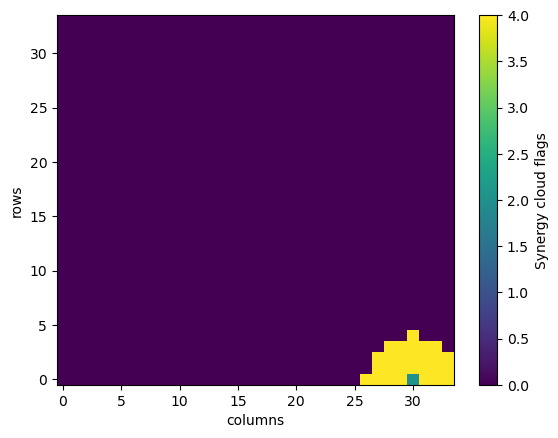

In [54]:
ds.CLOUD_flags.plot()

In [55]:
ds

<xarray.Dataset> Size: 542kB
Dimensions:       (rows: 34, columns: 34)
Coordinates:
    lat           (rows, columns) float32 5kB -15.21 -15.21 ... -15.31 -15.31
    lon           (rows, columns) float32 5kB 132.3 132.3 132.3 ... 132.4 132.4
Dimensions without coordinates: rows, columns
Data variables: (12/62)
    A550          (rows, columns) float64 9kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    AMIN          (rows, columns) float32 5kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    CLOUD_flags   (rows, columns) uint8 1kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    OLC_flags     (rows, columns) uint16 2kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    SDR_Oa01      (rows, columns) float64 9kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    SDR_Oa01_err  (rows, columns) float64 9kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    ...            ...
    SLN_flags     (rows, columns) uint32 5kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    SLO_flags     (rows, columns) uint32 5kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    SYN_flags     (rows, columns) uint16 2kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    T550          (rows, columns) float64 9kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    T550_err      (rows, columns) float64 9kB dask.array<chunksize=(34, 34), meta=np.ndarray>
    altitude      (rows, columns) float32 5kB dask.array<chunksize=(34, 34), meta=np.ndarray>
Attributes: (12/15)
    absolute_orbit_number:  47316
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2025-03-20T17:48:40Z
    history:                  2025-03-20T17:48:40Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    references:             S3IPF PDS 006 - i1r16 - Product Data Format Speci...
    resolution:             [ 300 300 ]
    source:                 IPF-SY-2 06.29
    start_time:             2025-03-19T00:58:53.713090Z
    stop_time:              2025-03-19T01:01:53.678190Z
    title:                  SYN L2, high resolution georeferencing data

In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
site = "AU-Dry"
scene = "S3A_SY_2_SYN____20181009T010230_20181009T010530_20181010T151851_0179_036_316_3240_LN2_O_NT_002.SEN3"
basedir = "/Net/Groups/BGI/work_4/scratch/jnelson/Sen3_cutouts"
_curr_dir = os.path.join(basedir, site, scene)

location = xr.open_dataset(_curr_dir+"/geolocation.nc").compute()
_dist = ((position.y - location.lat.values) ** 2 + (position.x - location.lon.values) ** 2)
idx, idy =  np.where(_dist==_dist.min())
idy = idy.tolist()[0]
idx = idx.tolist()[0]
x_range = slice(idx-10, idx+10)
y_range = slice(idy-10, idy+10)

plt.scatter(
    location.isel(rows=x_range, columns=y_range).lat.values.ravel(),
    location.isel(rows=x_range, columns=y_range).lon.values.ravel(),
)
plt.scatter(position.y, position.x)

NameError: name 'position' is not defined

<xarray.DataArray 'lat' (rows: 20, columns: 20)> Size: 2kB
array([[-15.227434 , -15.227971 , -15.228507 , -15.229044 , -15.22958  ,
        -15.230117 , -15.230653 , -15.23119  , -15.231726 , -15.232262 ,
        -15.232799 , -15.233335 , -15.233872 , -15.234408 , -15.234945 ,
        -15.235482 , -15.236018 , -15.236554 , -15.23709  , -15.237626 ],
       [-15.230028 , -15.230564 , -15.231101 , -15.231637 , -15.232174 ,
        -15.23271  , -15.233247 , -15.233783 , -15.23432  , -15.234856 ,
        -15.235392 , -15.235929 , -15.2364645, -15.237002 , -15.237539 ,
        -15.238075 , -15.238611 , -15.239147 , -15.239683 , -15.24022  ],
       [-15.232621 , -15.233158 , -15.233694 , -15.234231 , -15.234767 ,
        -15.235304 , -15.23584  , -15.236377 , -15.236913 , -15.237449 ,
        -15.237986 , -15.238523 , -15.2390585, -15.239596 , -15.240132 ,
        -15.240669 , -15.241205 , -15.241741 , -15.242277 , -15.242813 ],
       [-15.235215 , -15.235751 , -15.236288 , -15.236825 , -15.237361 ,
        -15.237898 , -15.238434 , -15.23897  , -15.239507 , -15.240043 ,
        -15.24058  , -15.241116 , -15.241652 , -15.242189 , -15.242726 ,
        -15.243262 , -15.243798 , -15.244334 , -15.24487  , -15.245407 ],
       [-15.237808 , -15.238345 , -15.238882 , -15.239418 , -15.239955 ,
        -15.240491 , -15.241027 , -15.241564 , -15.2421   , -15.242637 ,
        -15.243173 , -15.24371  , -15.244246 , -15.2447815, -15.245319 ,
        -15.245855 , -15.246391 , -15.246928 , -15.247464 , -15.248    ],
...
        -15.269022 , -15.269558 , -15.270095 , -15.270632 , -15.271168 ,
        -15.271704 , -15.272241 , -15.272777 , -15.2733135, -15.2738495,
        -15.274387 , -15.274923 , -15.27546  , -15.275996 , -15.276533 ],
       [-15.268932 , -15.269469 , -15.270005 , -15.270542 , -15.271079 ,
        -15.271615 , -15.272152 , -15.272689 , -15.273225 , -15.273762 ,
        -15.274298 , -15.274835 , -15.275371 , -15.2759075, -15.276444 ,
        -15.276981 , -15.277517 , -15.278054 , -15.27859  , -15.279126 ],
       [-15.271526 , -15.272062 , -15.272599 , -15.273136 , -15.273672 ,
        -15.274209 , -15.274745 , -15.275282 , -15.275819 , -15.276355 ,
        -15.276892 , -15.277428 , -15.277965 , -15.278501 , -15.279038 ,
        -15.279574 , -15.280111 , -15.280647 , -15.281183 , -15.281719 ],
       [-15.274119 , -15.274656 , -15.275192 , -15.275729 , -15.276266 ,
        -15.276802 , -15.277339 , -15.277876 , -15.278412 , -15.278949 ,
        -15.279485 , -15.280022 , -15.280558 , -15.281095 , -15.2816305,
        -15.282168 , -15.282704 , -15.28324  , -15.283776 , -15.284313 ],
       [-15.276713 , -15.277249 , -15.277786 , -15.278322 , -15.278859 ,
        -15.279396 , -15.279933 , -15.280469 , -15.281006 , -15.281542 ,
        -15.282079 , -15.282615 , -15.283152 , -15.283688 , -15.2842245,
        -15.284761 , -15.285297 , -15.285834 , -15.28637  , -15.286906 ]],
      dtype=float32)
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      DEM corrected latitude
    standard_name:  latitude
    units:          degrees_north
    valid_max:      90000000
    valid_min:      -90000000

In [1]:
[1,2,3][::-1]

[3, 2, 1]